# **LSTM으로 Samsung 주가 예측하기**
## **LSTM이란**
RNN(Recurrent Neural Networks의 한 종류, **순서**가 중요한 feature의 요소일 때 흔히 적용한다. (언어, 주가 등)  
따라서 **squence**를 저장하고 이를 학습에 활용한다.  


<p align="center"><img src="https://teddylee777.github.io/images/2020-02-14/RNN-simple-cell-versus-LSTM-cell-4.png" height="260"></p>


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
df_price=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/samsumg.csv')
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,20160222,23800.0,23840.0,23320.0,23500.0,20433.65430,8744950.0
1,20160223,23580.0,23780.0,23460.0,23620.0,20537.99805,7383700.0
2,20160224,23560.0,23580.0,23220.0,23440.0,20381.48633,7024200.0
3,20160225,23440.0,23740.0,23440.0,23580.0,20503.21680,6681750.0
4,20160226,23600.0,23740.0,23440.0,23440.0,20381.48633,8867200.0


일자, 시가, 고가, 저가, 거래량을 토대로 미래의 주가인 '종가'를 예측한다

In [4]:
pd.to_datetime(df_price['Date'], format='%Y%m%d')

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y%m%d')
df_price['year'] =df_price['Date'].dt.year
df_price['month'] =df_price['Date'].dt.month
df_price['date'] =df_price['Date'].dt.day

Text(0, 0.5, 'price')

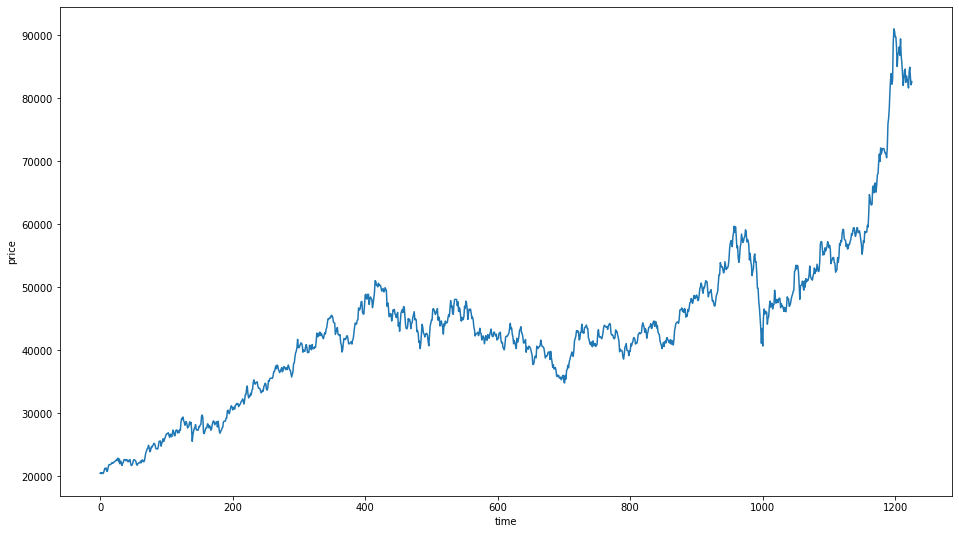

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 9))
sns.lineplot(y=df_price['Adj Close'], x=df_price.index)
plt.xlabel('time')
plt.ylabel('price')

##**Normalization**

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(df_price[scale_cols])
scaled

array([[5.38438528e-03, 3.55094237e-03, 1.50875075e-03, 8.88099467e-04,
        9.68366760e-02],
       [2.09392761e-03, 2.73149413e-03, 3.62100181e-03, 2.66429840e-03,
        8.17629563e-02],
       [1.79479509e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.77820547e-02],
       ...,
       [9.04277595e-01, 8.27915870e-01, 9.01931201e-01, 8.84547069e-01,
        2.02729598e-01],
       [8.93807957e-01, 8.19721388e-01, 8.88352444e-01, 8.68265246e-01,
        2.36170810e-01],
       [8.80346994e-01, 8.08795411e-01, 8.71756186e-01, 8.75666075e-01,
        2.86590351e-01]])

In [7]:
df = pd.DataFrame(scaled, columns=scale_cols)

## **train/test split**

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [10]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(980, 4) (980,)
(246, 4) (246,)


In [11]:
x_train

,Open,High,Low,Volume
0,0.005384,0.003551,0.001509,0.096837
1,0.002094,0.002731,0.003621,0.081763
2,0.001795,0.000000,0.000000,0.077782
3,0.000000,0.002185,0.003319,0.073990
4,0.002393,0.002185,0.003319,0.098190
...,...,...,...,...
975,0.570745,0.524720,0.573024,0.096788
976,0.558780,0.509697,0.550392,0.184641
977,0.543823,0.502868,0.545866,0.143418
978,0.557284,0.515160,0.548884,0.161583


##**sequence dataset 구성**

In [45]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-3]))
    return ds.batch(batch_size).prefetch(1)

In [46]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [47]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

##**Model**

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [62]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber() 사용
loss = Huber()
optimizer = Adam(0.001)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [63]:
import os
# 10번 동안 val_loss 개선이 없으면 학습 stop
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [64]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=10, 
                    #callbacks=[checkpoint, earlystopping])
 )

Epoch 1/10
30/30 [==============================] - 3s 27ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/10
30/30 [==============================] - 1s 14ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/10
30/30 [==============================] - 1s 14ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/10
30/30 [==============================] - 1s 15ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/10
30/30 [==============================] - 1s 14ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/10
30/30 [==============================] - 1s 14ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/10
30/30 [==============================] - 1s 15ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/10
30/30 [==============================] - 1s 14ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/10
30/30 [==============================

In [52]:
model.load_weights(filename)

In [53]:
pred = model.predict(test_data)
pred.shape

(226, 1)

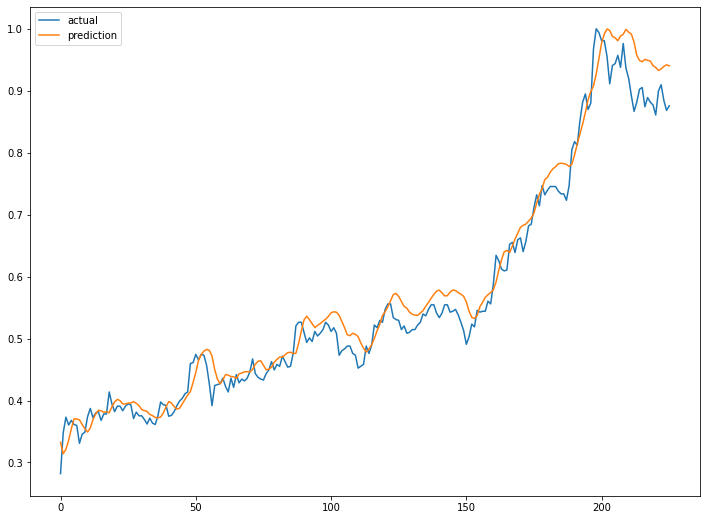

In [61]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()